In [1]:
import pickle
import faiss 
import torch
import numpy as np
import math
from asif import extract_candidate_sets_from_clusters
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
import sklearn
from operator import itemgetter 
from typing import Tuple, List, Type, Union

In [2]:
def relative_represent(y: torch.Tensor, basis: torch.Tensor, non_zeros: int = 800, max_gpu_mem_gb: int = 8) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the sparse decomposition of a tensor y with respect to a basis, 
    considering the available GPU memory.
    
    Args:
        y (torch.Tensor): Vectors to represent.
        basis (torch.Tensor): Basis to represent with respect to.
        non_zeros (int): Nonzero entries in the relative representation.
        max_gpu_mem_gb (int): Maximum GPU memory allowed to use in gigabytes.
        
    Returns:
        indices (torch.Tensor): Indices of the nonzero entries in each relative representation of y.
        values (torch.Tensor): Corresponding coefficients of the entries.
    """
    values, indices = torch.zeros((y.shape[0], non_zeros)), torch.zeros((y.shape[0], non_zeros), dtype=torch.long)

    free_gpu_mem = max_gpu_mem_gb * 1024 ** 3
    max_floats_in_mem = free_gpu_mem / 4
    max_chunk_y = max_floats_in_mem / basis.shape[0]
    n_chunks = int(y.shape[0] / max_chunk_y) + 1  
    chunk_y = int(y.shape[0] / n_chunks) + n_chunks

    with torch.no_grad():
        for c in range(n_chunks):
            in_prods = torch.einsum('ik, jk -> ij', y[c * chunk_y : (c + 1) * chunk_y], basis)
            values[c * chunk_y : (c + 1) * chunk_y], indices[c * chunk_y : (c + 1) * chunk_y] = torch.topk(in_prods, non_zeros, dim=1)
            del in_prods

    return indices.to('cpu'), values.to('cpu')

def relative_represent_2(y: torch.Tensor, basis: torch.Tensor, batch_size: int = 100,  k: int = 800, basis_batch_size: int = -1, computing_device: str = "cpu") -> Tuple[torch.Tensor, torch.Tensor]:

    values, indices = torch.zeros((y.shape[0], k)), torch.zeros((y.shape[0], k), dtype=torch.long)

    if basis_batch_size > 0:
        y = y.to("cpu")
        basis = basis.to("cpu")
        for basis_i in range(0, y.size()[0], basis_batch_size):
            basis_batch = basis[basis_i: min(basis_i+basis_batch_size, basis.size()[0])].to(computing_device)
            for i in tqdm(range(0, y.size()[0], batch_size), disable=batch_size==y.size()[0]):
                #in_prods = torch.einsum('ik, jk -> ij', y[c * chunk_y : (c + 1) * chunk_y], basis)
                yy = y[i: min(i+batch_size, y.size()[0])].to(computing_device)
                sim = (1 / (1 + torch.cdist(yy, basis_batch))) 
                top_k = torch.topk(sim, k, dim=1)
                values[i: min(i+batch_size, y.size()[0])], indices[i: min(i+batch_size, y.size()[0])] = top_k[0], top_k[1] + basis_i
                del sim
                del yy
                torch.cuda.empty_cache()
            del basis_batch

    else:
        for i in tqdm(range(0, y.size()[0], batch_size), disable=batch_size==y.size()[0]):
            #in_prods = torch.einsum('ik, jk -> ij', y[c * chunk_y : (c + 1) * chunk_y], basis)
            sim = (1 / (1 + torch.cdist( y[i: min(i+batch_size, y.size()[0])], basis))) 
            values[i: min(i+batch_size, y.size()[0])], indices[i: min(i+batch_size, y.size()[0])] = torch.topk(sim, k, dim=1)
            del sim
            torch.cuda.empty_cache()

    return indices.to('cpu'), values.to('cpu')

def sparsify(i: torch.Tensor, v: torch.Tensor, size: torch.Size) -> torch.sparse.FloatTensor:
    """
    Organize indices and values of n vectors into a single sparse tensor.

    Args:
        i (torch.Tensor): indices of non-zero elements of every vector. Shape: (n_vectors, nonzero elements)
        v (torch.Tensor): values of non-zero elements of every vector. Shape: (n_vectors, nonzero elements)
        size (torch.Size): shape of the output tensor

    Returns:
        torch.sparse.FloatTensor: sparse tensor of shape "size" (n_vectors, zero + nonzero elements)
    """
    flat_dim = len(i.flatten())
    coo_first_row_idxs = torch.div(torch.arange(flat_dim), i.shape[1], rounding_mode='floor')
    stacked_idxs = torch.cat((coo_first_row_idxs.unsqueeze(0), i.flatten().unsqueeze(0)), 0)
    return torch.sparse_coo_tensor(stacked_idxs, v.flatten(), size)


def normalize_sparse(tensor: torch.sparse.FloatTensor, nnz_per_row: int) -> torch.sparse.FloatTensor:
    """
    Normalize a sparse tensor by row.

    Args:
        tensor (torch.sparse.FloatTensor): The sparse tensor to normalize.
        nnz_per_row (int): The number of non-zero elements per row.

    Returns:
        torch.sparse.FloatTensor: The normalized sparse tensor.
    """
    norms = torch.sparse.sum(tensor * tensor, dim=1).to_dense()
    v = tensor._values().clone().detach().reshape(-1, nnz_per_row).t()
    v /= torch.sqrt(norms)
    return torch.sparse_coo_tensor(tensor._indices(), v.t().flatten(), tensor.shape)


def standardize(tensor):
    means = tensor.mean(dim=1, keepdim=True)
    stds = tensor.std(dim=1, keepdim=True)
    return (tensor - means) / stds

def compute_relative_coordinates(embeddings, anchors, k, p=7):

    embeddings = standardize(embeddings)
    anchors = standardize(anchors)
                
    sim = (1 / (1 + torch.cdist(embeddings, anchors)))
    
    #result = torch.zeros(sim.size())
        
    #for i, j in enumerate(torch.argsort(sim, descending=True)[:,:k]):
    #    result[i][j] = p
    indices = [[i, int(j)] for i,j in enumerate(torch.argsort(sim, descending=True)[:,:k])]
    values = [p] * len(indices)
    print(indices)
    print(values)
    print(sim.size())
    
    return torch.sparse_coo_tensor(indices=indices, values=values, size=sim.size())

def compute_self_relative_coordinates(embeddings, anchors, batch_size=1_000, denoise=True, k=800, p=8, device="cpu"):
    
    result = []

    for i in tqdm(range(0, embeddings.size()[0], batch_size), disable=batch_size==embeddings.size()[0]):
        self_relative_coordinates_batch = compute_relative_coordinates(embeddings[i:min(i+batch_size, embeddings.size()[0])], embeddings)
        self_relative_coordinates_batch = self_relative_coordinates_batch.to(device)
        relative_coordinates_vs_anchors = compute_relative_coordinates(self_relative_coordinates_batch, anchors, denoise=denoise, k=k, p=p)
        relative_coordinates_vs_anchors = relative_coordinates_vs_anchors.to("cpu")
        result.append(relative_coordinates_vs_anchors)
    
    return torch.vstack(result)

def evaluate_asif(relative_coordinates_1, relative_coordinates_2, n_of_samples):
    distances_1_to_2 = 1 / (1 + torch.cdist(relative_coordinates_1, relative_coordinates_2))

    # Get the max similarity for each vecotry in relative_coordinates_1
    max_values = distances_1_to_2.max(dim=1, keepdim=True)
    correct = 0

    for sample_index in range(n_of_samples):
        
        # Get indexes of elements with max similarity
        indexes = (distances_1_to_2[sample_index] == max_values.values[sample_index]).nonzero(as_tuple=True)[0]
        

        # Check if the index of the current element is among the elements with the maximum similarity
        if indexes.__contains__(sample_index):
            correct = correct + 1

        #retrieved_elements = itemgetter(*indexes)(elements_2)
        #if elements_2[sample_index] in retrieved_elements:
        #    correct = correct + 1
    
    return correct, int((correct/n_of_samples)*100)


def elbow(X, cluster_sizes, label = "Elbow curve"):
    distorsions = []
    result = {}
    for k in tqdm(cluster_sizes):
        kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions.append(kmeans.inertia_)
        result[k] = kmeans
    fig = plt.figure(figsize=(15, 5))
    plt.plot(cluster_sizes, distorsions)
    plt.xticks(cluster_sizes)
    plt.grid(True)
    plt.title(label)
    return result

In [3]:
data_folder = "data"
computing_device = "cuda:0"

In [4]:
il = pickle.load(open(f"{data_folder}/lyrics_indexes_similarities.pkl", "rb"))
vl = pickle.load(open(f"{data_folder}/lyrics_values_similarities.pkl", "rb"))

In [5]:
lyrics_embeddings = pickle.load(open(f"{data_folder}/lyrics_embeddings_sbert_roberta.pkl", "rb"))

In [6]:
lyrics_sparse = sparsify(il,vl,(lyrics_embeddings.size()[0],lyrics_embeddings.size()[0]))

In [7]:
s = torch.sparse.sum(lyrics_sparse ** 2)

: 

In [10]:
sims = normalize_sparse(lyrics_sparse, 800)

: 

In [ ]:
print("Loading dataset...")
lyrics = pickle.load(open(f"{data_folder}/lyrics.pkl", "rb"))
chords = pickle.load(open(f"{data_folder}/chords.pkl", "rb"))
artist_song = pickle.load(open(f"{data_folder}/artist_song.pkl", "rb"))


lyrics_embeddings = pickle.load(open(f"{data_folder}/lyrics_embeddings_sbert_roberta.pkl", "rb"))

In [4]:
n_of_samples = 10_000

sample = np.random.choice(np.intersect1d(np.unique(chords, return_index=True)[1], np.unique(lyrics, return_index=True)[1]), n_of_samples)

chords_embeddings_sampled = chords_embeddings[sample]
lyrics_embeddings_sampled = lyrics_embeddings[sample]

lyrics_sampled = itemgetter(*sample)(lyrics)
chords_sampled = itemgetter(*sample)(chords)

computing_device = "cuda:0"

chords_embeddings_sampled = chords_embeddings_sampled.to(torch.float32).to(computing_device)
lyrics_embeddings_sampled = lyrics_embeddings_sampled.to(torch.float32).to(computing_device)

In [17]:
relative_coordinates_chords = compute_relative_coordinates(chords_embeddings_sampled, chords_embeddings_sampled, k=1)

[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40], [41, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 46], [47, 47], [48, 48], [49, 49], [50, 50], [51, 51], [52, 52], [53, 53], [54, 54], [55, 55], [56, 56], [57, 57], [58, 58], [59, 59], [60, 60], [61, 61], [62, 62], [63, 63], [64, 64], [65, 65], [66, 66], [67, 67], [68, 68], [69, 69], [70, 70], [71, 71], [72, 72], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92], [93, 93], [94, 94], [95, 95], [96, 96], [97, 97], [98, 98], [99, 99], [100, 100], [101, 1

RuntimeError: number of dimensions must be sparse_dim (10000) + dense_dim (0), but got 2

In [5]:
# test chords to lyrics

ks = [p for p in range(1, 10)] + [2**p for p in [4, 5, 6, 7]]

for k in ks:
    relative_coordinates_chords = compute_relative_coordinates(chords_embeddings_sampled, chords_embeddings_sampled, k=k)
    relative_coordinates_lyrics = compute_relative_coordinates(lyrics_embeddings_sampled, lyrics_embeddings_sampled, k=k)
    correct_chords_to_lyrics, accuracy_chord_to_lyrics =  evaluate_asif(relative_coordinates_chords, relative_coordinates_lyrics, n_of_samples)
    correct_lyrics_to_chords, accuracy_lyrics_to_chords = evaluate_asif(relative_coordinates_lyrics, relative_coordinates_chords, n_of_samples)
    print(k, correct_chords_to_lyrics, accuracy_chord_to_lyrics, correct_lyrics_to_chords, accuracy_lyrics_to_chords)

RuntimeError: numel: integer multiplication overflow

In [5]:
# For each cluster get the nearest and farest to the cluster centers
n_of_random_anchors = 100
k=2


lyrics_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[:n_of_random_anchors,:]
chord_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[:n_of_random_anchors,:]
lyrics_not_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[n_of_random_anchors:,]
chords_not_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[n_of_random_anchors:,]

# chords to anchords

relative_coordinates_anchors_chords = compute_relative_coordinates(chord_anchors_embeddings, chords_not_anchors_embeddings, k=k)
relative_coordinates_anchors_lyrics = compute_relative_coordinates(lyrics_anchors_embeddings, lyrics_not_anchors_embeddings, k=k)

relative_coordinates_anchors_chords.size(), relative_coordinates_lyrics.size()

relative_coordinates_anchors_chords = compute_relative_coordinates(chords_not_anchors_embeddings, chords_not_anchors_embeddings, k=k)
relative_coordinates_anchors_lyrics = compute_relative_coordinates(lyrics_anchors_embeddings, lyrics_not_anchors_embeddings, k=k)


NameError: name 'relative_coordinates_lyrics' is not defined

In [ ]:
not_anchors_indexes[1100]


1216

In [27]:
torch.cdist(relative_coordinates_chords[:1], relative_coordinates_lyrics).min(dim=1, keepdim=True)

torch.return_types.min(
values=tensor([[0.]]),
indices=tensor([[9135]]))

In [28]:
relative_coordinates_lyrics[9135]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7071, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [32]:
lyrics[sample[not_anchors_indexes[9135]]]

'Chegou, chegou, sim senhor, chegou sem anunciar, '

In [33]:
lyrics[sample[not_anchors_indexes[0]]]

'  Faz ouvir a tua voz pois já é tempo de adorar '

In [35]:
artist_song[sample[not_anchors_indexes[9135]]]
artist_song[sample[not_anchors_indexes[0]]]

{'artist': 'Nívea Soares', 'song': 'Ouço a Voz do Meu Amado'}

In [29]:
relative_coordinates_lyrics[0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.7071, 0.7071, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000])

In [ ]:
# For each cluster get the nearest and farest to the cluster centers
n_of_random_anchors = 1000
anchors_indexes = random.sample(range(0, n_of_samples), n_of_random_anchors)
not_anchors_indexes = list(set(range(0, n_of_samples)) - set(anchors_indexes))

lyrics_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[anchors_indexes]
chord_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[anchors_indexes]
lyrics_not_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[not_anchors_indexes]
chords_not_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[not_anchors_indexes]


ks = [p for p in range(1, 10)] + [2**p for p in [4, 5, 6, 7]]

for k in ks:
    relative_coordinates_chords = compute_relative_coordinates(chords_not_anchors_embeddings, chord_anchors_embeddings, k=k)
    relative_coordinates_lyrics = compute_relative_coordinates(lyrics_not_anchors_embeddings, lyrics_anchors_embeddings, k=k)
    correct_chords_to_lyrics, accuracy_chord_to_lyrics =  evaluate_asif(relative_coordinates_chords, relative_coordinates_lyrics, len(not_anchors_indexes) )
    correct_lyrics_to_chords, accuracy_lyrics_to_chords = evaluate_asif(relative_coordinates_lyrics, relative_coordinates_chords, len(not_anchors_indexes))
    print(k, correct_chords_to_lyrics, accuracy_chord_to_lyrics, correct_lyrics_to_chords, accuracy_lyrics_to_chords)

1 1285 14 122 1
2 148 1 111 1
3 148 1 152 1
4 179 1 188 2
5 181 2 195 2
6 166 1 136 1
7 100 1 60 0
8 91 1 35 0
9 59 0 35 0
16 11 0 10 0
32 7 0 8 0
64 5 0 9 0
128 3 0 2 0


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:02<00:00,  3.28it/s]


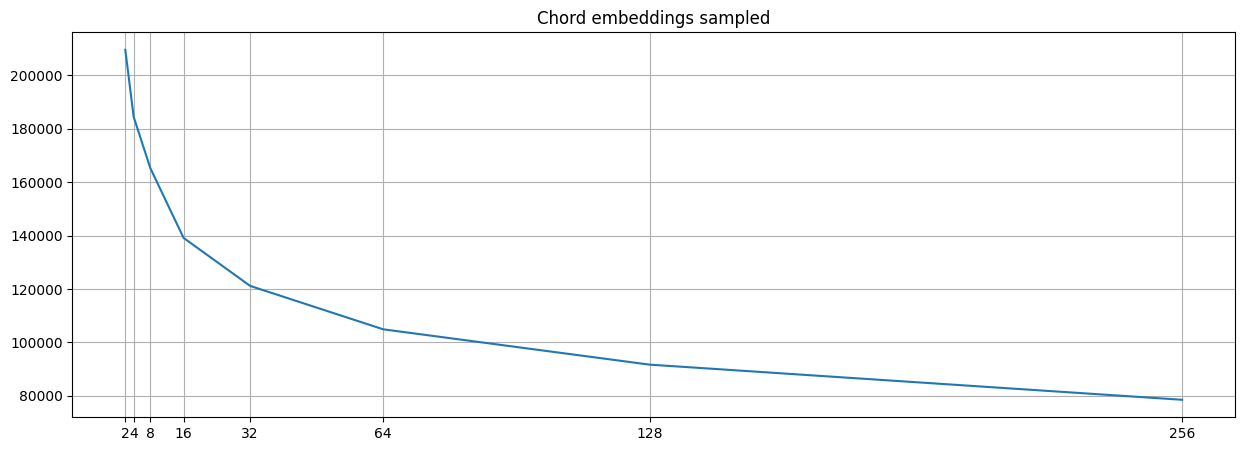

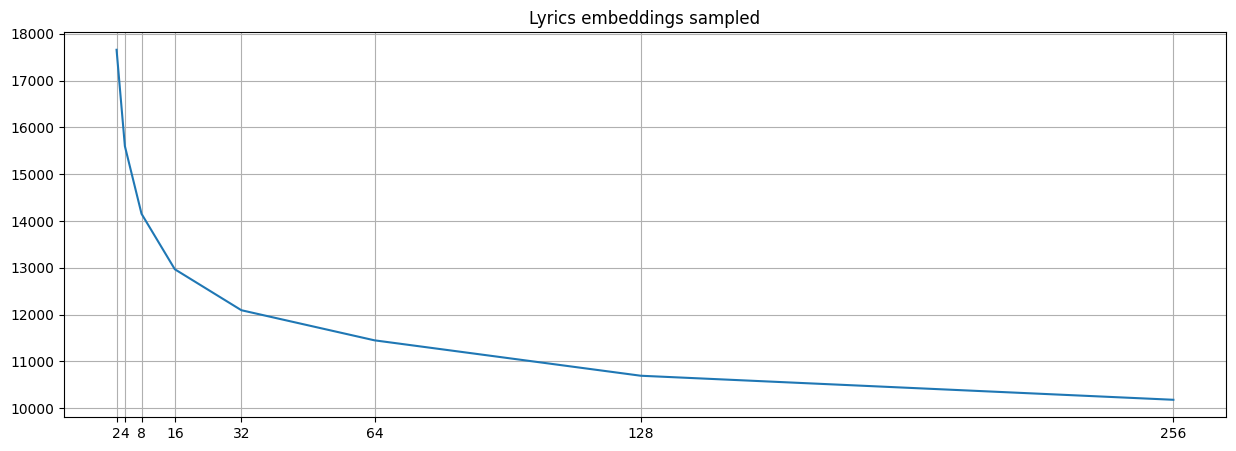

In [6]:
chords_kmeans = elbow(chords_embeddings_sampled.cpu().numpy(), [2**i for i in range(1,9)], label="Chord embeddings sampled")
lyrics_kmeans = elbow(lyrics_embeddings_sampled.cpu().numpy(), [2**i for i in range(1,9)], label="Lyrics embeddings sampled")

In [7]:
best_n_of_clusters = 16
chords_kmeans = chords_kmeans[16]
lyrics_kmeans = lyrics_kmeans[16]

chords_cluster_centers = torch.from_numpy(chords_kmeans.cluster_centers_).to(computing_device)
lyrics_cluster_centers = torch.from_numpy(lyrics_kmeans.cluster_centers_).to(computing_device)

In [8]:
# For each cluster get the nearest and farest to the cluster centers

chord_dist = torch.cdist(chords_cluster_centers, chords_embeddings_sampled)
chords_anchors = chord_dist.argmax(dim=1).tolist()
chords_anchors.extend(chord_dist.argmin(dim=1).tolist())
chords_anchors = list(set(chords_anchors))

lyrics_dist = torch.cdist(lyrics_cluster_centers, lyrics_embeddings_sampled)
lyrics_anchors = lyrics_dist.argmax(dim=1).tolist()
lyrics_anchors.extend(lyrics_dist.argmin(dim=1).tolist())
lyrics_anchors = list(set(lyrics_anchors))

anchors_from_dataset = list(set(lyrics_anchors + chords_anchors))

lyrics_anchors_embeddings = lyrics_embeddings_sampled.to(computing_device)[anchors_from_dataset]
chord_anchors_embeddings = chords_embeddings_sampled.to(computing_device)[anchors_from_dataset]

print(lyrics_anchors_embeddings.size(), chord_anchors_embeddings.size())

lyrics_relative_coordinates_anchors = torch.nn.functional.normalize(1 / (1 + torch.cdist(lyrics_embeddings_sampled, lyrics_anchors_embeddings)))
chords_relative_coordinates_anchors = torch.nn.functional.normalize(1 / (1 + torch.cdist(chords_embeddings_sampled, chord_anchors_embeddings)))

print(evaluate_asif(chords_relative_coordinates_anchors, lyrics_relative_coordinates_anchors, n_of_samples))
print(evaluate_asif(lyrics_relative_coordinates_anchors, chords_relative_coordinates_anchors, n_of_samples))

torch.Size([39, 768]) torch.Size([39, 256])
(40, 0.004)
(4, 0.0004)


In [12]:
torch.zeros((4_000_000,1000))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [43]:
dist.min(dim=1).indices

tensor([6712, 5357, 4582,  ...,  253, 9478, 4717], device='cuda:0')

In [37]:
lyrics_relative_coordinates_anchors

tensor([[0.1369, 0.1418, 0.1365,  ..., 0.1406, 0.1595, 0.1760],
        [0.1994, 0.1682, 0.1780,  ..., 0.1669, 0.1634, 0.1554],
        [0.1710, 0.1456, 0.1770,  ..., 0.1613, 0.1770, 0.1678],
        ...,
        [0.1794, 0.1666, 0.1760,  ..., 0.1641, 0.1535, 0.1562],
        [0.1746, 0.1737, 0.1727,  ..., 0.1882, 0.1610, 0.1593],
        [0.1396, 0.1401, 0.1423,  ..., 0.1409, 0.1562, 0.1721]],
       device='cuda:0')

In [21]:
lyrics_anchors_embeddings_rc = compute_relative_coordinates(lyrics_embeddings_sampled.to(torch.float32), lyrics_anchors_embeddings, k = len(lyrics_anchors_embeddings), p=1)
chords_anchors_embeddings_rc = compute_relative_coordinates(chords_embeddings_sampled.to(torch.float32), chord_anchors_embeddings, k = len(chords_embeddings_sampled), p=1)

chords_anchors_embeddings_rc.size(), lyrics_anchors_embeddings_rc.size()

(torch.Size([10000, 39]), torch.Size([10000, 39]))

In [26]:
lyrics_anchors_embeddings_rc[0].min()

tensor(0.1601)

In [22]:
correct_chords_to_lyrics =  evaluate_asif(chords_anchors_embeddings_rc, lyrics_anchors_embeddings_rc, n_of_samples=n_of_samples)
correct_lyrics_to_chords = evaluate_asif(lyrics_anchors_embeddings_rc, chords_anchors_embeddings_rc, n_of_samples=n_of_samples)
print(k, correct_chords_to_lyrics, correct_lyrics_to_chords)

9 10000 10000


In [ ]:

anchors_from_dataset_embeddings = torch.vstack([lyrics_anchors_embeddings_rc, chords_anchors_embeddings_rc])
anchors_from_dataset_embeddings.to(computing_device)

In [ ]:
# test chords to lyrics

ks = [p for p in range(1, 10)]
p = 1

kc = math.ceil(n_of_samples / best_n_of_clusters)

for k in ks:
    relative_coordinates_chord_clusters = compute_relative_coordinates(chords_cluster_centers, chords_embeddings_sampled, k=kc, p=p).to(computing_device)
    relative_coordinates_lyrics_clusters = compute_relative_coordinates(lyrics_cluster_centers, lyrics_embeddings_sampled, k=kc, p=p).to(computing_device)

    self_relative_coordinates_chords = compute_self_relative_coordinates(chords_embeddings_sampled, relative_coordinates_chord_clusters, batch_size=len(chords_embeddings_sampled), device=computing_device, k=k, p=p)
    self_relative_coordinates_lyrics = compute_self_relative_coordinates(lyrics_embeddings_sampled, relative_coordinates_lyrics_clusters, batch_size=len(lyrics_embeddings_sampled), device=computing_device, k=k, p=p)
    correct_chords_to_lyrics =  evaluate_asif(self_relative_coordinates_chords, self_relative_coordinates_lyrics, n_of_samples=n_of_samples)
    correct_lyrics_to_chords = evaluate_asif(self_relative_coordinates_lyrics, self_relative_coordinates_chords, n_of_samples=n_of_samples)
    print(k, correct_chords_to_lyrics, correct_lyrics_to_chords)

    anchors = torch.vstack([relative_coordinates_chord_clusters, relative_coordinates_lyrics_clusters])
    anchors = anchors.to(computing_device)
    self_relative_coordinates_chords_anchors = compute_self_relative_coordinates(chords_embeddings_sampled, anchors, batch_size=len(chords_embeddings_sampled), device=computing_device, k=k, p=p)
    self_relative_coordinates_lyrics_anchors = compute_self_relative_coordinates(lyrics_embeddings_sampled, anchors, batch_size=len(lyrics_embeddings_sampled), device=computing_device, k=k, p=p)
    correct_chords_to_lyrics =  evaluate_asif(self_relative_coordinates_chords_anchors, self_relative_coordinates_lyrics_anchors, n_of_samples=n_of_samples)
    correct_lyrics_to_chords = evaluate_asif(self_relative_coordinates_lyrics_anchors, self_relative_coordinates_chords_anchors, n_of_samples=n_of_samples)
    print(k, correct_chords_to_lyrics, correct_lyrics_to_chords)

1 853 853
1 2644 652
2 705 637
2 804 413
3 466 476
3 227 127
4 248 318
4 160 74
5 126 289
5 130 104
6 72 300
6 69 70
7 57 199
7 23 49
8 113 276
8 34 110
9 105 188
9 28 80
